In [1]:
import itertools
import pickle
import random
from collections import defaultdict
from itertools import zip_longest

import torch
from networkx.algorithms.centrality import degree_centrality
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import degree, from_networkx, to_networkx
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *

In [2]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states


class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):

        topk_pooling = TopKPooling(
            self.args.dim, ratio=min(sizes_1.item(), sizes_2.item())
        )
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1, score1),
                    (x_pooled_2, edge_index_pooled_2, perm2, score2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        clusters = []

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 188
Number of classes: 2
Number of node features: 7
Average number of nodes per graph: 17
Max number of nodes in a graph: 28
Min number of nodes in a graph: 10
Class distribution:
 - Class 1: 125 graphs (66.49%)
 - Class 0: 63 graphs (33.51%)


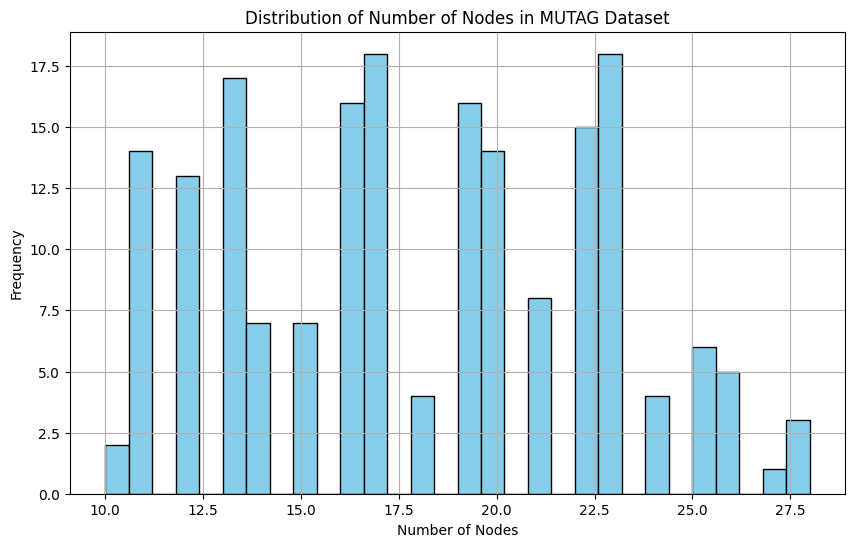

Small graphs: 114
Medium graphs: 74
Large graphs: 0


In [3]:
dataset = TUDataset(
    root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
)


(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

In [4]:
def train(model, optimizer, pairs, labels, batch_size, title):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()

    plt.figure(figsize=(12, 5))
    plt.title(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [5]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [6]:
def max_common_subgraph(data1, data2, mp=None):
    def pyg_to_nx(data):
        return to_networkx(data, to_undirected=True)

    def nx_to_pyg(G):
        return from_networkx(G)

    def mc_split(G1, G2, mp):
        best_mapping = []
        best_edge_count = 0
        max_size = 0

        def edge_count(mapping, G1, G2):
            count = 0
            for (v1, w1), (v2, w2) in itertools.combinations(mapping, 2):
                if G1.has_edge(v1, v2) and G2.has_edge(w1, w2):
                    count += 1
            return count

        def search(mapping, future, best_mapping, best_edge_count):
            nonlocal max_size
            current_edge_count = edge_count(mapping, G1, G2)
            if len(mapping) > max_size or (
                len(mapping) == max_size and current_edge_count > best_edge_count
            ):
                max_size = len(mapping)
                best_mapping = mapping[:]
                best_edge_count = current_edge_count
            bound = len(mapping) + sum(min(len(g), len(h)) for g, h in future)
            if bound <= max_size:
                return best_mapping, best_edge_count

            G, H = min(future, key=lambda x: max(len(x[0]), len(x[1])))
            v = max(G, key=lambda x: G1.degree[x])
            for w in H:
                if (mp != None) and ((v, w) not in mp):
                    continue
                future_prime = []
                for G_prime, H_prime in future:
                    G_prime_adj = [
                        u for u in G_prime if u != v and u in G1.neighbors(v)
                    ]
                    H_prime_adj = [
                        u for u in H_prime if u != w and u in G2.neighbors(w)
                    ]
                    if G_prime_adj and H_prime_adj:
                        future_prime.append((G_prime_adj, H_prime_adj))
                    G_prime_non_adj = [
                        u for u in G_prime if u != v and u not in G1.neighbors(v)
                    ]
                    H_prime_non_adj = [
                        u for u in H_prime if u != w and u not in G2.neighbors(w)
                    ]
                    if G_prime_non_adj and H_prime_non_adj:
                        future_prime.append((G_prime_non_adj, H_prime_non_adj))
                best_mapping, best_edge_count = search(
                    mapping + [(v, w)], future_prime, best_mapping, best_edge_count
                )
            G_prime = [u for u in G if u != v]
            future.remove((G, H))
            if G_prime:
                future.append((G_prime, H))
            best_mapping, best_edge_count = search(
                mapping, future, best_mapping, best_edge_count
            )
            return best_mapping, best_edge_count

        future = [(list(G1.nodes), list(G2.nodes))]
        best_mapping, best_edge_count = search(
            [], future, best_mapping, best_edge_count
        )

        return best_mapping

    G1 = pyg_to_nx(data1)
    G2 = pyg_to_nx(data2)
    mapping = mc_split(G1, G2, mp)
    common_nodes = [v for v, _ in mapping]
    subgraph = G1.subgraph(common_nodes)
    return nx_to_pyg(subgraph)

In [7]:
top_10 = [
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
]

In [8]:
def extract_embeddings_and_attention(
    model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
):
    model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)
    embeddings = model.layer_outputs
    attentions = model.layer_cross_attentions
    return embeddings, attentions


def extract_dynamic_attention_nodes(attentions, threshold=0.1):
    attention_nodes = []
    softmax = torch.nn.Softmax(dim=1)

    for layer_idx, (cross_graph_attention, a_x, a_y) in enumerate(attentions):
        dynamic_attention_nodes_1_to_2 = []
        dynamic_attention_nodes_2_to_1 = []

        a_x = a_x[0]
        a_y = a_y[0]

        assert a_x.shape[0] == a_y.shape[0]
        assert a_x.shape[1] == a_y.shape[1]

        # # Apply softmax normalization
        # a_x = softmax(a_x)
        # a_y = softmax(a_y.T).T

        for i, x_attention in enumerate(a_x):
            strong_attention_indices = (x_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_1_to_2.append(strong_attention_indices.tolist())

        for j, y_attention in enumerate(a_y.T):
            strong_attention_indices = (y_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_2_to_1.append(strong_attention_indices.tolist())

        attention_nodes.append(
            (dynamic_attention_nodes_1_to_2, dynamic_attention_nodes_2_to_1)
        )

    for i in range(len(attention_nodes)):
        for j in range(i):
            if attention_nodes[i] == attention_nodes[j]:
                for k in range(len(attention_nodes[i][0])):
                    attention_nodes[i][0][k] = []
                for k in range(len(attention_nodes[i][1])):
                    attention_nodes[i][1][k] = []
                break

    return attention_nodes


def print_attentions(attention_nodes, d):
    n_layers = len(attention_nodes)
    max_length = max(
        max(len(attn_1_to_2), len(attn_2_to_1))
        for attn_1_to_2, attn_2_to_1 in attention_nodes
    )

    col_width = 30

    if d == "12":
        print(" Graph 1 to Graph 2:".ljust(73))
    else:
        print(" Graph 2 to Graph 1:".ljust(73))
    print("=" * 130)

    for node_idx in range(max_length):
        line = []

        for layer_idx in range(n_layers):
            if d == "12":
                if node_idx < len(attention_nodes[layer_idx][0]):
                    attn_1_to_2 = attention_nodes[layer_idx][0][node_idx]
                    attn_1_to_2_str = f"{node_idx}: {attn_1_to_2}".ljust(col_width)
                else:
                    attn_1_to_2_str = "".ljust(col_width)

                line.append(attn_1_to_2_str)

            else:
                if node_idx < len(attention_nodes[layer_idx][1]):
                    attn_2_to_1 = attention_nodes[layer_idx][1][node_idx]
                    attn_2_to_1_str = f"{node_idx}: {attn_2_to_1}".ljust(col_width)
                else:
                    attn_2_to_1_str = "".ljust(col_width)

                line.append(attn_2_to_1_str)

        g1_to_g2_str = " | ".join(line)

        print(f"{g1_to_g2_str}")

    print("=" * 130)

In [9]:
# (graph1, graph2, attention_nodes) = torch.load("info.pt")

In [10]:
def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


# pairs = mutual_pairs(attention_nodes, 1)
# pairs.sort()
# reversed_pairs = [(p[1], p[0]) for p in pairs]
# reversed_pairs.sort()
# print(reversed_pairs)

In [11]:
def create_subgraphs(pattern, graph1, graph2):
    g1_nodes = set()
    g2_nodes = set()
    for g1_node, g2_node in pattern.items():
        g1_nodes.add(g1_node)
        g2_nodes.add(g2_node)

    g1_node_map = {node: idx for idx, node in enumerate(g1_nodes)}
    g2_node_map = {node: idx for idx, node in enumerate(g2_nodes)}

    g1_edge_index = []
    for edge in graph1.edge_index.t():
        if edge[0].item() in g1_nodes and edge[1].item() in g1_nodes:
            g1_edge_index.append(
                [g1_node_map[edge[0].item()], g1_node_map[edge[1].item()]]
            )

    g2_edge_index = []
    for edge in graph2.edge_index.t():
        if edge[0].item() in g2_nodes and edge[1].item() in g2_nodes:
            g2_edge_index.append(
                [g2_node_map[edge[0].item()], g2_node_map[edge[1].item()]]
            )

    g1_subgraph = Data(
        x=graph1.x[list(g1_nodes)],
        edge_index=torch.tensor(g1_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g1_nodes), dtype=torch.long),
    )
    g2_subgraph = Data(
        x=graph2.x[list(g2_nodes)],
        edge_index=torch.tensor(g2_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g2_nodes), dtype=torch.long),
    )

    return g1_subgraph, g2_subgraph


def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


def print_patterns(patterns, graph1, graph2):
    for i in patterns:
        g1_subgraph, g2_subgraph = create_subgraphs(i, graph1, graph2)

        if nx.is_isomorphic(
            to_networkx(g1_subgraph, to_undirected=True),
            to_networkx(g2_subgraph, to_undirected=True),
        ):

            plot_mutag(
                g1_subgraph,
                g2_subgraph,
                perm1=g1_subgraph.original_node_ids,
                perm2=g2_subgraph.original_node_ids,
            )

In [12]:
import networkx as nx
import torch
from torch_geometric.utils import degree
import time


class MCS:
    def __init__(self, mp):
        self.mp = mp
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.time_limit = 5
        self.start_time = None

    def find_mcs(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if time.time() - self.start_time > self.time_limit:
            return

        state = (frozenset(M.items()), frozenset(neighbors1), frozenset(neighbors2))
        if state in self.visited:
            return
        self.visited.add(state)

        # Compute the number of edges in the current mapping
        edge_count = self.count_edges(M, G1, G2)

        if len(M) > self.max_size or (
            len(M) == self.max_size and edge_count > self.edge_count
        ):
            self.max_size = len(M)
            self.edge_count = edge_count
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size and edge_count == self.edge_count:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(n1, n2, M, G1, G2):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and not (
                    G2.edge_index[1][G2.edge_index[0] == n2] == M[neighbor.item()]
                ).any()
            ):
                return False

        return True

    def count_edges(self, M, G1, G2):
        edge_count = 0
        for u1, v1 in M.items():
            for u2, v2 in M.items():
                if u1 != u2:
                    u1_v1_exists = (
                        (G1.edge_index[0] == u1) & (G1.edge_index[1] == u2)
                    ).any() or (
                        (G1.edge_index[0] == u2) & (G1.edge_index[1] == u1)
                    ).any()
                    u2_v2_exists = (
                        (G2.edge_index[0] == v1) & (G2.edge_index[1] == v2)
                    ).any() or (
                        (G2.edge_index[0] == v2) & (G2.edge_index[1] == v1)
                    ).any()
                    if u1_v1_exists and u2_v2_exists:
                        edge_count += 1
        return edge_count

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

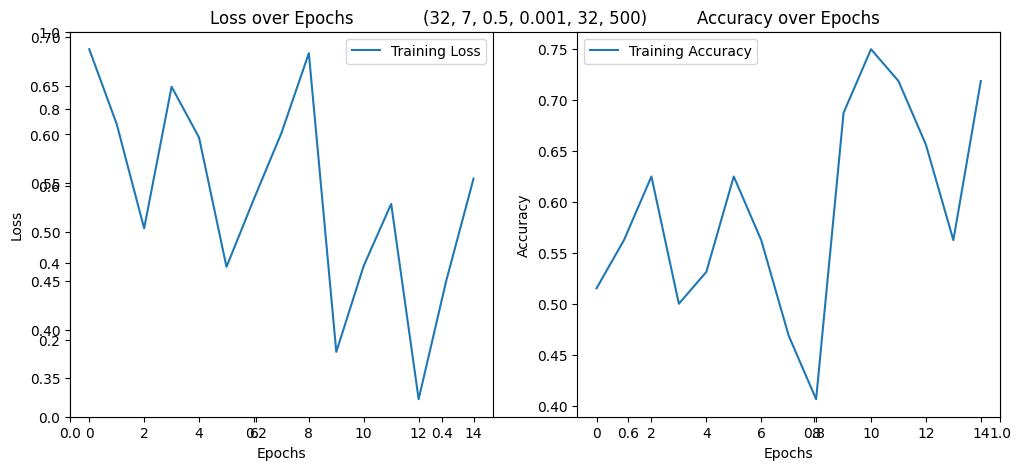

In [13]:
hyperparams = (32, 7, 0.5, 0.001, 32, 500)
newargs = NewArgs(*hyperparams)
model = GraphMatchingNetwork(newargs)
optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
train(model, optimizer, pairs, labels, newargs.batch_size, str(hyperparams))

In [14]:
def is_correct(cluster, c):
    if c == "class_0":
        return is_cycle(cluster)
    elif c == "class_1":
        return is_complete(cluster)
    elif c == "class_2":
        return is_line(cluster)
    elif c == "class_3":
        return is_star(cluster)


def find_max_core_subgraph(graph_list):
    def count_subgraph_occurrences(graph_list):
        subgraph_counts = [0] * len(graph_list)
        for i, graph1 in enumerate(graph_list):
            g1 = to_networkx(graph1)
            for j, graph2 in enumerate(graph_list):
                if i != j:
                    g2 = to_networkx(graph2)
                    matcher = nx.algorithms.isomorphism.GraphMatcher(g2, g1)
                    if matcher.subgraph_is_isomorphic():
                        subgraph_counts[i] += 1
        return subgraph_counts

    # Count subgraph occurrences for each graph
    subgraph_counts = count_subgraph_occurrences(graph_list)

    # Find the graph with the maximum subgraph count and, in case of ties, the largest one
    max_count = max(subgraph_counts)
    candidates = [i for i, count in enumerate(subgraph_counts) if count == max_count]
    max_core_subgraph = max(candidates, key=lambda idx: graph_list[idx].num_nodes)

    return graph_list[max_core_subgraph]

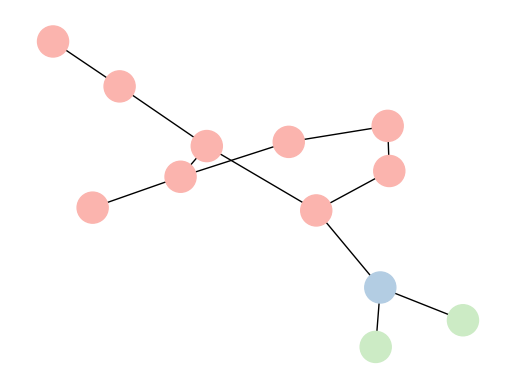

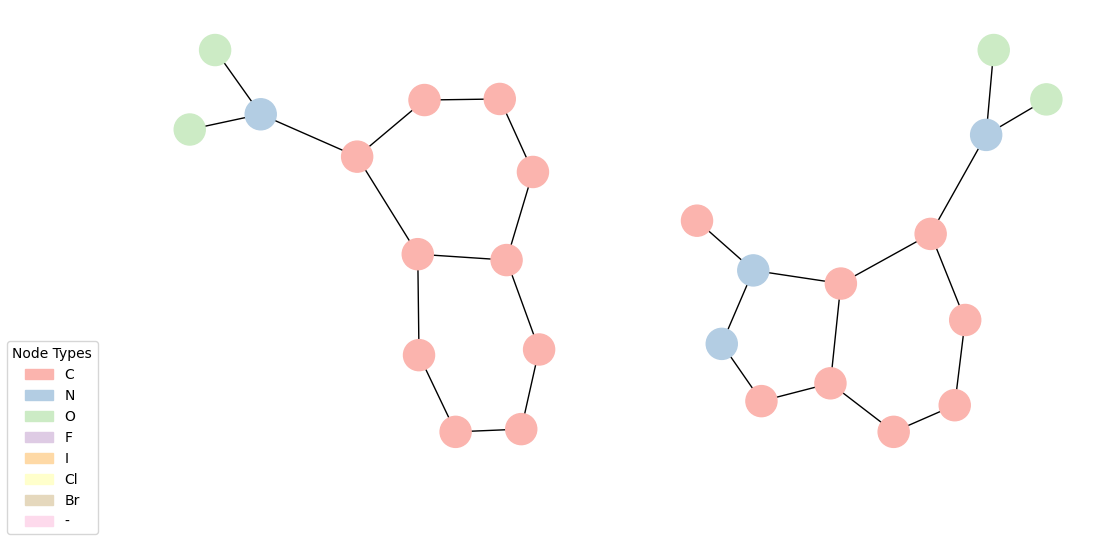

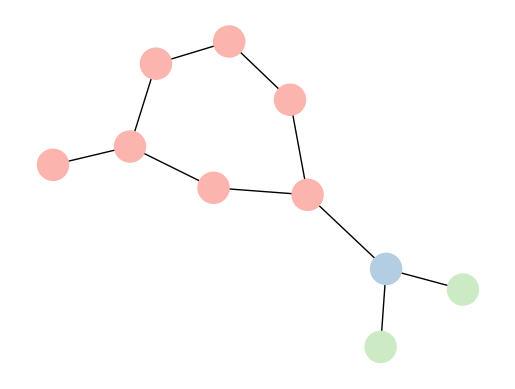

In [27]:
summaries = []
graph_pairs = []
while True:
    c = f"class_{0}"
    idx1 = random.sample(range(len(classes[c])), 1)[0]
    idx2 = random.sample(range(len(classes[c])), 1)[0]
    graph1, graph2 = classes[c][idx1], classes[c][idx2]
    model.eval()
    # plot_mutag(graph1, graph2)
    feats_1, edge_index_1 = graph1.x, graph1.edge_index
    feats_2, edge_index_2 = graph2.x, graph2.edge_index
    sizes_1 = torch.tensor([len(graph1.x)])
    sizes_2 = torch.tensor([len(graph2.x)])
    emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
        feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    )

    embeddings, attentions = extract_embeddings_and_attention(
        model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    )

    most_nodes = 0
    largest_summary = 0
    t_of_largest = 0
    layer_of_largest = 0
    ts = []

    graph_pairs.append((graph1, graph2))

    br = False
    pattern_lens = []
    most_nodes = 0
    largest_summary = None
    t_of_largest = 0
    layer_of_largest = 0
    ts = []
    for i in range(5):
        for t in [0.08]:
            attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=t)
            mp = mutual_pairs(attention_nodes, i)
            vf2 = MCS(mp)
            patterns = vf2.find_mcs(graph1, graph2)
            # print(len(patterns))
            if patterns != []:
                pattern = patterns[0]

                # if len(pattern) > largest_summary:
                #     largest_summary = len(pattern)
                # else:
                #     break

                # print(len(pattern))

                g1_subgraph, g2_subgraph = create_subgraphs(pattern, graph1, graph2)

                if (
                    nx.is_isomorphic(
                        to_networkx(g1_subgraph, to_undirected=True),
                        to_networkx(g2_subgraph, to_undirected=True),
                    )
                    and len(pattern) > 2
                ):
                    summary = Data(
                        x=(g1_subgraph.x),
                        edge_index=g1_subgraph.edge_index,
                    )

                    if len(pattern) > most_nodes:
                        most_nodes = len(pattern)
                        largest_summary = summary
                        t_of_largest = t
                        layer_of_largest = i + 1

                    # plot_mutag(summary)

    summaries.append(largest_summary)

    nx_graph1 = to_networkx(graph1, to_undirected=True)
    nx_graph2 = to_networkx(graph2, to_undirected=True)
    ismags = nx.isomorphism.ISMAGS(nx_graph1, nx_graph2)

    largest_common_subgraph = create_subgraphs(
        list(ismags.largest_common_subgraph())[0], graph1, graph2
    )[0]
    # largest_common_subgraph = max_common_subgraph(graph1, graph2, [])

    if (
        largest_summary.num_nodes < (largest_common_subgraph.num_nodes)
    ) and nx.is_connected(to_networkx(largest_common_subgraph, to_undirected=True)):
        plot_mutag(largest_common_subgraph)
        plot_mutag(graph1, graph2)
        plot_mutag(largest_summary)
        break

In [ ]:
# torch.save((graph1, graph2, attentions), "mutag_class_2_0.04_v8.pt")

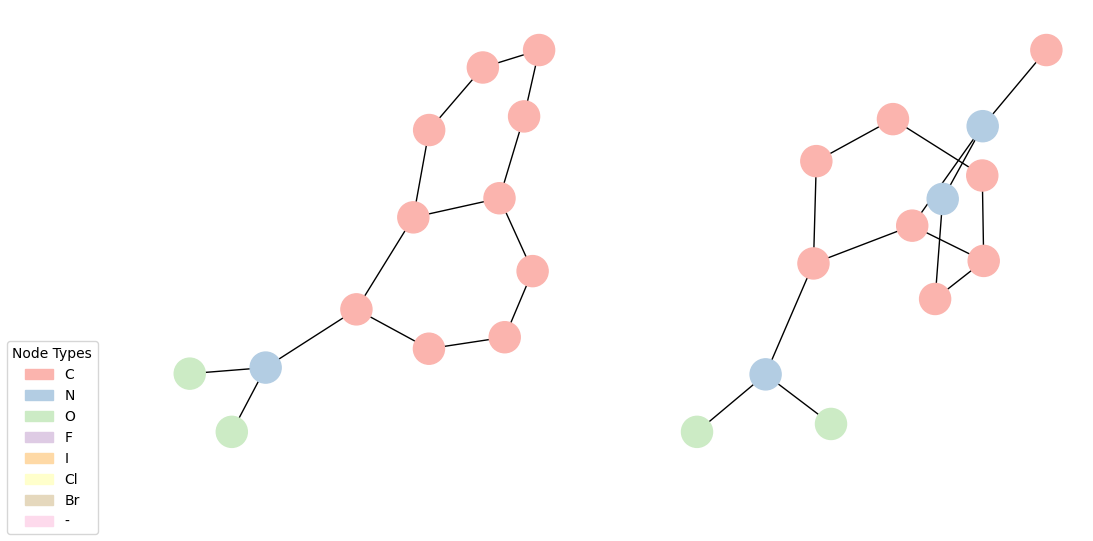

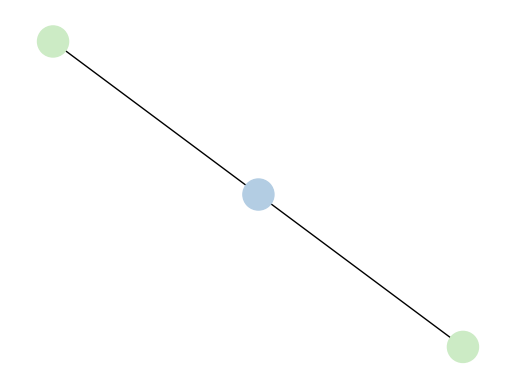

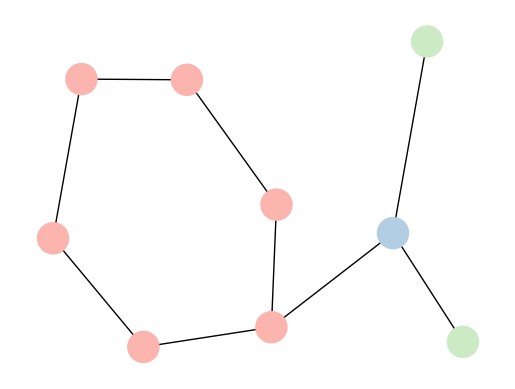

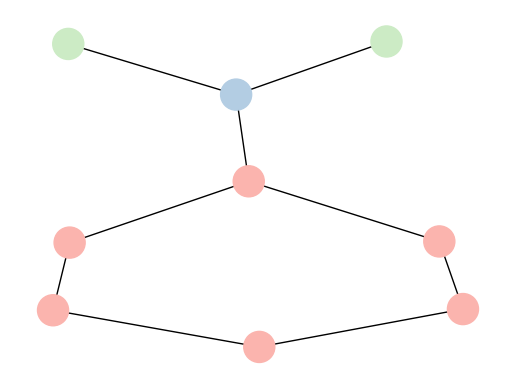

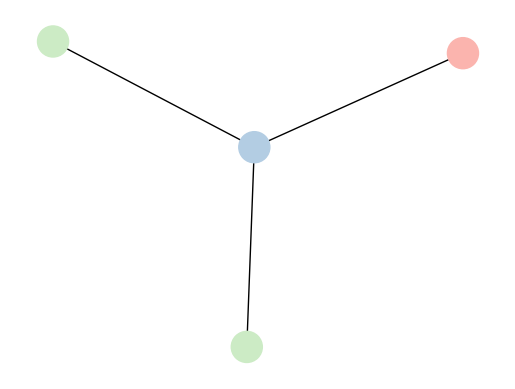

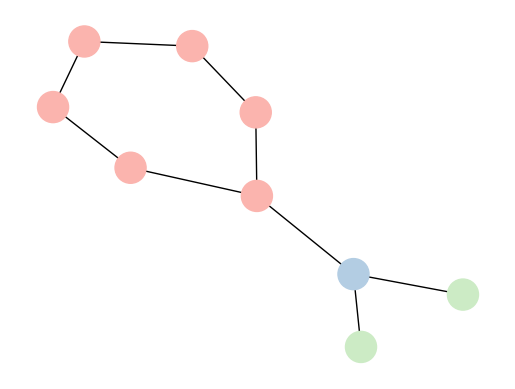

In [30]:
plot_mutag(graph1, graph2)

largest_summary = None
most_nodes = 0

for i in range(5):
    for t in [0.1]:
        attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=t)
        mp = mutual_pairs(attention_nodes, i)
        vf2 = MCS(mp)
        patterns = vf2.find_mcs(graph1, graph2)
        # print(len(patterns))
        if patterns != []:
            pattern = patterns[0]

            # if len(pattern) > largest_summary:
            #     largest_summary = len(pattern)
            # else:
            #     break

            # print(len(pattern))

            g1_subgraph, g2_subgraph = create_subgraphs(pattern, graph1, graph2)

            if (
                nx.is_isomorphic(
                    to_networkx(g1_subgraph, to_undirected=True),
                    to_networkx(g2_subgraph, to_undirected=True),
                )
                and len(pattern) > 2
            ):
                summary = Data(
                    x=(g1_subgraph.x),
                    edge_index=g1_subgraph.edge_index,
                )

                if len(pattern) > most_nodes:
                    most_nodes = len(pattern)
                    largest_summary = summary
                    t_of_largest = t
                    layer_of_largest = i + 1

                plot_mutag(summary)

plot_mutag(largest_summary)

In [31]:
# torch.save((graph1, graph2, attentions), "mutag_good_01.pt")

In [ ]:
# plot_mutag(find_core_subgraph(summaries))

In [ ]:
def plot_mutag(
    graph1, graph2=None, original_x1=None, perm1=None, original_x2=None, perm2=None
):
    import matplotlib
    import matplotlib.patches as mpatches

    colormap = matplotlib.colormaps.get_cmap("Pastel1")

    color_map = {
        0: colormap(0),
        1: colormap(1),
        2: colormap(2),
        3: colormap(3),
        4: colormap(4),
        5: colormap(5),
        6: colormap(6),
        "other": colormap(7),
    }

    def plot_single_graph(graph, ax, original_x=None, perm=None):
        G = to_networkx(graph, to_undirected=True)

        node_colors = []
        node_labels = {}

        if original_x is not None and perm is not None:
            mapped_x = original_x[perm[: graph.num_nodes]]
            for node in range(graph.num_nodes):
                one_hot = mapped_x[node].tolist()
                try:
                    node_type = one_hot.index(1)
                except ValueError:
                    node_type = "other"
                node_colors.append(color_map[node_type])
                node_labels[node] = perm[node].item()
        else:
            for node in range(graph.num_nodes):
                one_hot = graph.x[node].tolist()
                try:
                    node_type = one_hot.index(1)
                except ValueError:
                    node_type = "other"
                node_colors.append(color_map[node_type])
                node_labels[node] = perm[node].item() if (perm is not None) else node

        pos = nx.spring_layout(G)
        nx.draw(
            G,
            pos,
            node_color=node_colors,
            with_labels=False,
            labels=node_labels,
            node_size=500,
            font_weight="bold",
            ax=ax,
        )

    legend_handles = [
        mpatches.Patch(color=colormap(0), label="C"),
        mpatches.Patch(color=colormap(1), label="N"),
        mpatches.Patch(color=colormap(2), label="O"),
        mpatches.Patch(color=colormap(3), label="F"),
        mpatches.Patch(color=colormap(4), label="I"),
        mpatches.Patch(color=colormap(5), label="Cl"),
        mpatches.Patch(color=colormap(6), label="Br"),
        # mpatches.Patch(color=colormap(7), label="-"),
    ]

    if graph2 is None:
        fig, ax = plt.subplots()
        plot_single_graph(graph1, ax, original_x1, perm1)
        fig.legend(handles=legend_handles, loc="lower left", title="Node Types")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plot_single_graph(graph1, axes[0], original_x1, perm1)
        plot_single_graph(graph2, axes[1], original_x2, perm2)
        axes[0].set_title("Graph 1")
        axes[1].set_title("Graph 2")
        fig.legend(handles=legend_handles, loc="lower left", title="Node Types")

    plt.show()

In [ ]:
# idx1 = random.sample(range(len(classes["class_0"])), 1)[0]
# idx2 = random.sample(range(len(classes["class_1"])), 1)[0]
# graph1, graph2 = classes["class_0"][idx1], classes["class_1"][idx2]

# plot_mutag(graph1, graph2)